In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import numpy as np
import joblib
from PIL import Image
from torchvision import transforms
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import math
import matplotlib.pyplot as plt



##  Step 1: Feature Extraction with DINOv2

We started by using **DINOv2**, a self-supervised vision transformer developed by Meta AI, to extract rich and descriptive embeddings from plant images.  
DINOv2 captures visual patterns without needing labeled data, making it ideal for few-shot learning.  
These embeddings serve as the foundation for our classification step, allowing the model to recognize plants based on visual similarity.

In [ ]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2 = dinov2.to(device)

torch.save(dinov2, "dinov2_model.pt")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
"""
Extracts feature embeddings from the input image using DINOv2.
The output embedding will be passed to the classifier for prediction.
"""
def extract_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = dinov2(tensor).squeeze().cpu().numpy()
    return emb


## 📂 Dataset Access

If you'd like to access the dataset used , you can find it in this [Google Drive folder](https://drive.google.com/drive/folders/1Azhc9Ux4FNw0sIqZu-d_GadWhWNVQhjI?usp=sharing).

In [ ]:
"""
Loops through all labeled folders of plant images,
extracts feature embeddings using DINOv2 for each image,
and stores them along with their corresponding labels for training.
"""

base_path = "/content/drive/MyDrive/Plant_image"
X, y = [], []

for label in os.listdir(base_path):
    folder_path = os.path.join(base_path, label)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(folder_path, filename)
                try:
                    emb = extract_embedding(image_path)
                    X.append(emb)
                    y.append(label)
                except Exception as e:
                    print(f" Error in {image_path}: {e}")

X = np.array(X)
y = np.array(y)


In [ ]:
"""
Encodes the string labels into numerical values
to make them compatible with the classifier.
"""

le = LabelEncoder()
y_encoded = le.fit_transform(y)

## Step 2: Classification using Few-Shot Learning (SVM)

After extracting the embeddings using DINOv2, we used a Support Vector Machine (SVM) as a classifier.  
SVM is well-suited for few-shot learning, where we have limited training data per class.  
We trained it on the embeddings and evaluated its accuracy using 5-fold cross-validation to ensure the model can generalize well.

In [ ]:


clf = SVC(kernel='linear')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y_encoded, cv=skf, scoring='accuracy')

print("\n Cross-validation scores:", scores)
print(" Average accuracy: {:.2f}%".format(scores.mean() * 100))




 Cross-validation scores: [1.         1.         0.90909091 1.         1.        ]
 Average accuracy: 98.18%


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
clf_final = SVC(kernel='linear')
clf_final.fit(X, y_encoded)
joblib.dump(clf_final, "plant_identifier_SVM_model.pkl")
joblib.dump(le, "plant_label_encoder.pkl")

['plant_label_encoder.pkl']

## Step 3: Real-world Testing

We tested the system using real plant images taken personally at Tuwaiq Academy and from our home garden.  
The model showed strong performance and accurately predicted the plant names, confirming its effectiveness in real-world scenarios.

In [ ]:


clf = joblib.load("/content/svm_final_model.pkl")
le = joblib.load("/content/label_encoder_final.pkl")


def test_multiple_images(image_paths, cols=3):
    rows = math.ceil(len(image_paths) / cols)
    plt.figure(figsize=(cols * 5, rows * 5))

    for i, path in enumerate(image_paths):
        try:
            emb = extract_embedding(path)
            pred = clf.predict(emb)[0]
            class_name = le.inverse_transform([pred])[0]

            img = Image.open(path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(f"{class_name}", fontsize=16)
            plt.axis('off')
        except Exception as e:
            print(f" Error in {path}: {e}")

    plt.tight_layout()
    plt.show()

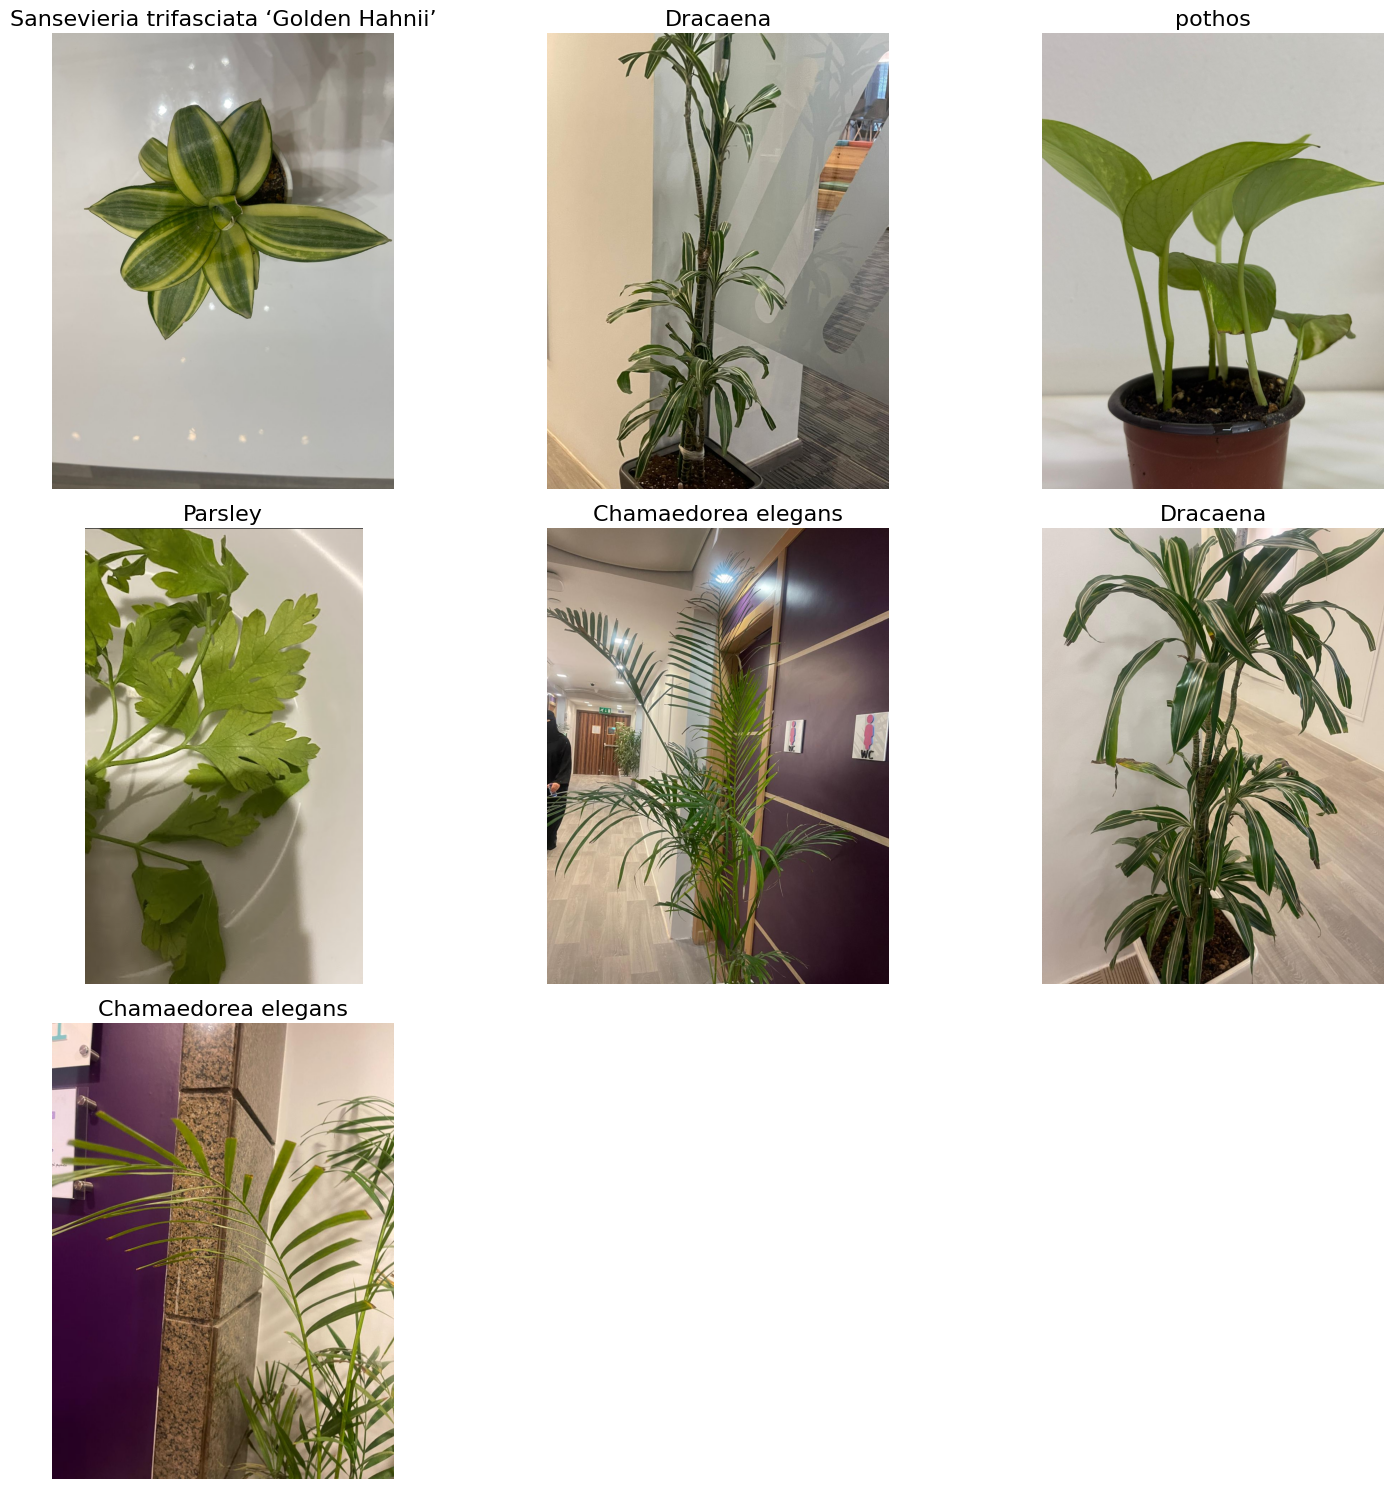

In [ ]:
test_images = [
    "/content/WhatsApp Image 1446-11-13 at 20.18.03 (2).jpeg",
    "/content/WhatsApp Image 1446-11-13 at 18.23.14 (1).jpeg",
    "/content/WhatsApp Image 1446-11-15 at 20.12.45.jpeg",
    "/content/m.jpg",
    "/content/WhatsApp Image 1446-11-13 at 18.23.14 (3).jpeg",
    "/content/WhatsApp Image 1446-11-13 at 18.23.14 (2).jpeg",
    "/content/WhatsApp Image 1446-11-13 at 18.23.12 (2).jpeg",

]

test_multiple_images(test_images)